# ---------------------------- Reddit Post Classifier ----------------------------

In this interactive python notebook, we will be exploring the dataset of top posts on reddit related to popular reddit communities - Machine Learning, Artificial Intelligence, and Data Science. Another dataset includes all comments on those posts. 

The target is to predict the subreddit category given the comment on a post. Let's jump right into it.

In [1]:
## import required libraries
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ravirajpurohit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ravirajpurohit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
## define a dictionary to compare all model performances and analyse results
perf_comp = {'title':[],'train_acc':[],'test_acc':[],'valid_acc':[],'clf':[]}

## ------------------------------ Data Exploration ------------------------------

In [3]:
## load the dataset; remove the useless columns
dataset = pd.read_csv('data/Top_Posts.csv').drop(columns=['post_url','date-time'])
dataset.head()

,post_id,post_title,subreddit,flair_text,score,comments,upvote_ratio,year
0,gh1dj9,[Project] From books to presentations in 10s w...,MachineLearning,Project,7798,186,0.99,2020
1,kuc6tz,[D] A Demo from 1993 of 32-year-old Yann LeCun...,MachineLearning,Discussion,5851,133,0.98,2021
2,g7nfvb,[R] First Order Motion Model applied to animat...,MachineLearning,Research,4761,111,0.97,2020
3,lui92h,[N] AI can turn old photos into moving Images ...,MachineLearning,News,4688,230,0.97,2021
4,ohxnts,[D] This AI reveals how much time politicians ...,MachineLearning,Discussion,4568,228,0.96,2021


In [4]:
## check how many items in each class
dataset.subreddit.value_counts()

artificial         999
MachineLearning    998
datascience        990
Name: subreddit, dtype: int64

In [5]:
## check each column's information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2987 entries, 0 to 2986
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   post_id       2987 non-null   object 
 1   post_title    2987 non-null   object 
 2   subreddit     2987 non-null   object 
 3   flair_text    2441 non-null   object 
 4   score         2987 non-null   int64  
 5   comments      2987 non-null   int64  
 6   upvote_ratio  2987 non-null   float64
 7   year          2987 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 186.8+ KB


In [6]:
## check each colummn's description
dataset.describe()

,score,comments,upvote_ratio,year
count,2987.000000,2987.000000,2987.000000,2987.000000
mean,480.092400,72.939739,0.950683,2020.276197
std,519.716958,92.253969,0.039040,1.783035
min,78.000000,0.000000,0.660000,2013.000000
25%,183.000000,19.000000,0.940000,2019.000000
50%,360.000000,45.000000,0.960000,2020.000000
75%,542.500000,99.500000,0.980000,2022.000000
max,7798.000000,2361.000000,1.000000,2023.000000


In [7]:
## import another dataset containing comments for each post
dataset_add = pd.read_csv('data/Top_Posts_Comments.csv')
dataset_add.head()

,post_id,comment
0,gh1dj9,Twitter thread: [https://twitter.com/cyrildiag...
1,gh1dj9,The future 🤯
2,gh1dj9,Simple yet very useful. Thank you for sharing ...
3,gh1dj9,"Almost guaranteed, Apple will copy your idea i..."
4,gh1dj9,Ohh the nightmare of making this into a stable...


In [8]:
## add comments to the main dataset and merge the two
dataset = dataset.merge(right=dataset_add.groupby(by='post_id', as_index=False).agg(list),
                        how='inner', 
                        on='post_id')

In [9]:
dataset.head()

,post_id,post_title,subreddit,flair_text,score,comments,upvote_ratio,year,comment
0,gh1dj9,[Project] From books to presentations in 10s w...,MachineLearning,Project,7798,186,0.99,2020,[Twitter thread: [https://twitter.com/cyrildia...
1,kuc6tz,[D] A Demo from 1993 of 32-year-old Yann LeCun...,MachineLearning,Discussion,5851,133,0.98,2021,[The fact that they also had to know the locat...
2,g7nfvb,[R] First Order Motion Model applied to animat...,MachineLearning,Research,4761,111,0.97,2020,"[I cant stop watching the actress, it’s like s..."
3,lui92h,[N] AI can turn old photos into moving Images ...,MachineLearning,News,4688,230,0.97,2021,[This seems like the next museum gimmick where...
4,ohxnts,[D] This AI reveals how much time politicians ...,MachineLearning,Discussion,4568,228,0.96,2021,"[Voting takes forever. What exactly are they ""..."


In [10]:
## check if the post title contains title character everywhere
[i.split(']')[0] for i in dataset.iloc[0:,1].values]

['[Project',
 '[D',
 '[R',
 '[N',
 '[D',
 '[D',
 'data siens',
 'I made a robot that punishes me if it detects that if I am procrastinating on my assignments [P',
 'The pain and excitement',
 '[D',
 '[Project',
 'Shout Out to All the Mediocre Data Scientists Out There',
 "Let's keep this on...",
 '[P',
 'Guys, we’ve been doing it wrong this whole time',
 'It’s never too early',
 '[D',
 'how about that data integrity yo',
 'Didn’t have to chart this one 🔥',
 '[P',
 'Wait until you see the data in hospitals...',
 'Imposter Syndrome is a problem for me and I think this is the main contributor',
 '[R',
 'DS at a glance',
 '[R',
 'Remember it always.',
 '[P',
 '[P',
 '[R',
 '[R',
 'I created a four-page Data Science Cheatsheet to assist with exam reviews, interview prep, and anything in-between',
 '[P',
 '[P',
 'I want to be free of this pain.',
 'True that',
 '[D',
 '[D',
 'A little seasonal homage... [P',
 '[D',
 'Selling my own damn data (cartoon by artist Jeremy Nguyen)',
 'Graph of gra

In [11]:
data = dataset.copy()
data['comment'] = data.apply(lambda row: row['post_title']+
                             ' '+
                             ' '.join(np.array(row['comment']).astype(str)), 
                             axis=1)
data.drop(columns=['post_title'], inplace=True)

In [12]:
data

,post_id,subreddit,flair_text,score,comments,upvote_ratio,year,comment
0,gh1dj9,MachineLearning,Project,7798,186,0.99,2020,[Project] From books to presentations in 10s w...
1,kuc6tz,MachineLearning,Discussion,5851,133,0.98,2021,[D] A Demo from 1993 of 32-year-old Yann LeCun...
2,g7nfvb,MachineLearning,Research,4761,111,0.97,2020,[R] First Order Motion Model applied to animat...
3,lui92h,MachineLearning,News,4688,230,0.97,2021,[N] AI can turn old photos into moving Images ...
4,ohxnts,MachineLearning,Discussion,4568,228,0.96,2021,[D] This AI reveals how much time politicians ...
...,...,...,...,...,...,...,...,...
2977,slx33m,artificial,Discussion,84,6,0.90,2022,We live in beautiful times where you can learn...
2978,k9otbj,artificial,News,78,1,0.97,2020,Yann LeCun’s Deep Learning Course Free From NY...
2979,k2orib,artificial,Self Promotion,80,2,0.95,2020,You Can Now Learn for FREE: 9 Courses by Googl...
2980,ex9w4w,artificial,news,80,10,0.97,2020,"Chatbot trained on ""public domain social media..."


In [13]:
data.subreddit.value_counts()

MachineLearning    998
artificial         994
datascience        990
Name: subreddit, dtype: int64

## --------------------------- Data Preprocessing ---------------------------

In [14]:
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    """
    steps like -
    converts all characters to lower
    splits sentence to words
    removes non-alphabetical words
    
    Parameters
    ----------
    text - string

    Returns
    -------
    text - string (preprocessed)
    """
    text = text.lower()
    text = text.replace('"','').replace('\n','').strip()
    ## word_tokenize splits a sentence into words linguistically
    text = nltk.word_tokenize(text)
    text = [word for word in text if (word.isalpha() and word not in stopwords.words('english'))]
    
    word_list = [lemmatizer.lemmatize(word) for word in text]
    
    return ' '.join(word_list)

In [15]:
data['comment'] = data['comment'].apply(preprocess)

In [16]:
data

,post_id,subreddit,flair_text,score,comments,upvote_ratio,year,comment
0,gh1dj9,MachineLearning,Project,7798,186,0.99,2020,project book presentation ar ml twitter thread...
1,kuc6tz,MachineLearning,Discussion,5851,133,0.98,2021,demo yann lecun showing world first convolutio...
2,g7nfvb,MachineLearning,Research,4761,111,0.97,2020,r first order motion model applied animate pai...
3,lui92h,MachineLearning,News,4688,230,0.97,2021,n ai turn old photo moving image link given co...
4,ohxnts,MachineLearning,Discussion,4568,228,0.96,2021,ai reveals much time politician stare phone wo...
...,...,...,...,...,...,...,...,...
2977,slx33m,artificial,Discussion,84,6,0.90,2022,live beautiful time learn machine learning ai ...
2978,k9otbj,artificial,News,78,1,0.97,2020,yann lecun deep learning course free nyu link ...
2979,k2orib,artificial,Self Promotion,80,2,0.95,2020,learn free course google artificial intelligen...
2980,ex9w4w,artificial,news,80,10,0.97,2020,chatbot trained public domain social medium co...


## ---------------------------------- TF-IDF ----------------------------------

In one of earlier projects, I worked with Naive Bayes algorithm to classify textual data into categories. This time, let's try the TF-IDF method. It is a handy algorithm that uses the frequency of words to determine how relevant those words are to a given document. It calculates a score for each word based on its frequency in a document and its rarity in the overall corpus. This algorithm is widely used for information retrieval, document classification, and text mining tasks.

The main advantage of using TF-IDF over the Naive Bayes classifier for text classification is that it can help to improve the accuracy of the classification by weighting the features based on their relevance. TF-IDF takes into account the frequency of the words in the document and the rarity of the words in the overall corpus, which can help to identify important features and reduce the impact of common features that are not informative for classification. Naive Bayes, on the other hand, does not consider the relevance of the features and assumes that all features are equally important.

### Experiment 1. A
### -------------------------------- Use comment as Feature -------------------------------------

In [17]:
X = data.comment
y, y_org = data.subreddit.factorize()

In [18]:
## split the dataset into train-test-valid stratified split; to keep the ratio of classes same
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42, 
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.10, 
                                                  random_state=42, 
                                                  stratify=y_train)

In [19]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
X_train.shape, y_train.shape

((2146,), (2146,))

In [21]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
y_pred_train = text_clf.predict(X_train)
y_pred_test = text_clf.predict(X_test)
y_pred_val = text_clf.predict(X_val)

In [23]:
print(f'Train Accuracy - {round(100*accuracy_score(y_train, y_pred_train),2)}%')
print(f'Test Accuracy - {round(100*accuracy_score(y_test, y_pred_test),2)}%')
print(f'Validation Accuracy - {round(100*accuracy_score(y_val, y_pred_val),2)}%\n')

print(f'Classification Report - \n{classification_report(y_test, y_pred_test)}')

Train Accuracy - 66.96%
Test Accuracy - 60.8%
Validation Accuracy - 64.02%

Classification Report - 
              precision    recall  f1-score   support

           0       0.50      0.81      0.62       200
           1       0.74      0.96      0.84       198
           2       1.00      0.05      0.09       199

    accuracy                           0.61       597
   macro avg       0.74      0.61      0.51       597
weighted avg       0.74      0.61      0.51       597



In [24]:
perf_comp['title'].append('TF-IDF NB - Comment')
perf_comp['train_acc'].append(round(100*accuracy_score(y_train, y_pred_train),2))
perf_comp['test_acc'].append(round(100*accuracy_score(y_test, y_pred_test),2))
perf_comp['valid_acc'].append(round(100*accuracy_score(y_val, y_pred_val),2))
perf_comp['clf'].append(text_clf)

In [25]:
y_org

Index(['MachineLearning', 'datascience', 'artificial'], dtype='object')

### Observations -

The classifier shows moderate accuracy i.e. around 60-65%, for these particular data samples. The classification report further clarifies the model performance. Here, the output labels are -
- 0 - MachineLearning
- 1 - datascience
- 2 - artificial

The classification report provides an evaluation of the classifier's performance for each class, as well as an overall evaluation of its accuracy, precision, recall, and F1-score. The overall model accuracy is okay and consistent among train, test and validation datasets. But looking at the classification report, we come to know that the model is not performing any good for predicting posts for "artificial" category using this dataset. The best performance is for predicting "datascience" posts, where we see 0.84 F1-score, which is pretty good.

The macro-average and weighted-average F1-scores are relatively low, also indicating that the classifier's overall performance is not very good, and it is struggling to correctly classify the posts.

Overall, these results suggest that the classifier could benefit from further improvements, such as using a more sophisticated algorithm or improving the quality of the dataset and the preprocessing steps.

### Experiment 1. B
### -------------------------------- Use flair_text as Feature -------------------------------------

Looking at the dataset, we can see that there is one more column which seems to contain the relevent information that can identify the category of the reddit post. Let us explore this column and try to use this as a machine learning feature.

In [26]:
data.flair_text.value_counts()

Discussion              727
Project                 324
News                    282
Research                240
Career                  149
Fun/Trivia              140
My project              120
Job Search               79
Education                71
Projects                 50
news                     47
Self Promotion           37
Tooling                  30
Meta                     23
discussion               19
Question                 18
AGI                      16
Tutorial                 14
Ethics                   13
Networking                6
Discusssion               6
my project                4
tutorial                  4
fake                      3
Shameless Self Promo      3
Misleading                2
Request                   2
question                  2
Can we impute it?         1
Let's Discuss This        1
RIP Medium                1
opinion                   1
misleading                1
Name: flair_text, dtype: int64

In [27]:
data.flair_text.isna().sum()

546

In [28]:
print(f'{round(100*data.flair_text.isna().sum()/data.shape[0],2)}% of column is NaN')

18.31% of column is NaN


Usually, when we have missing data, we can fill using techniques like most-frequent. But since the percentage of NaN in this feature is significant, hence we should not fill these instances. 

Rather, let's work with the rest of the data.

In [29]:
X = data.flair_text.dropna().astype(str).apply(preprocess)

y, y_org = data[~data.flair_text.isna()].subreddit.factorize()

In [30]:
## split the dataset into train-test-valid stratified split; to keep the ratio of classes same
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.15, 
                                                    random_state=42, 
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.10, 
                                                  random_state=42, 
                                                  stratify=y_train)

In [31]:
## pipeline for model
text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [32]:
X_train.shape, y_train.shape

((1863,), (1863,))

In [33]:
## fit the pipeline
text_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [34]:
y_pred_train = text_clf.predict(X_train)
y_pred_test = text_clf.predict(X_test)
y_pred_val = text_clf.predict(X_val)

print(f'Train Accuracy - {round(100*accuracy_score(y_train, y_pred_train),2)}%')
print(f'Test Accuracy - {round(100*accuracy_score(y_test, y_pred_test),2)}%')
print(f'Validation Accuracy - {round(100*accuracy_score(y_val, y_pred_val),2)}%\n')

print(f'Classification Report - \n{classification_report(y_test, y_pred_test)}')

Train Accuracy - 58.56%
Test Accuracy - 63.11%
Validation Accuracy - 61.84%

Classification Report - 
              precision    recall  f1-score   support

           0       0.59      0.56      0.57       138
           1       0.65      0.83      0.73       130
           2       0.68      0.47      0.55        98

    accuracy                           0.63       366
   macro avg       0.64      0.62      0.62       366
weighted avg       0.63      0.63      0.62       366



In [35]:
perf_comp['title'].append('TF-IDF NB - Flair Text')
perf_comp['train_acc'].append(round(100*accuracy_score(y_train, y_pred_train),2))
perf_comp['test_acc'].append(round(100*accuracy_score(y_test, y_pred_test),2))
perf_comp['valid_acc'].append(round(100*accuracy_score(y_val, y_pred_val),2))
perf_comp['clf'].append(text_clf)

In [36]:
y_org

Index(['MachineLearning', 'datascience', 'artificial'], dtype='object')

### Observations -

Again, the classifier shows moderate accuracy i.e. around 63%, for these particular data samples. The classification report further clarifies the model performance. Here, the output labels are -
- 0 - MachineLearning
- 1 - datascience
- 2 - artificial

The classification report provides an evaluation of the classifier's performance for each class, as well as an overall evaluation of its accuracy, precision, recall, and F1-score. The overall model accuracy is okay and consistent among train, test and validation datasets. 

#### Improvement -
Looking at the classification report, we see the improvement in the performance as the model is pretty consistent among all the three categories. The best performance is again for predicting "datascience" posts, where we see 0.83 F1-score, which is pretty good.

The macro-average and weighted-average F1-scores are relatively low but more balance than before, indicating that there has been improvement in classifier's overall performance.

However, there is still a good scope of improvement.

The observation here is, that the keywords in flair_text column are significant as well to balance the model performance.

## -------------------------------- Random Forest Classifier -------------------------------------

Random Forest is a popular machine learning algorithm that is well-suited for classification problems like the one at hand. It is an ensemble learning method that builds multiple decision trees and combines them to make the final predictions. In the case of a classification problem, each decision tree in the random forest is trained on a random subset of the data, and the final prediction is made by taking a majority vote from the individual trees.

Let's try the Random Forest method for this dataset.

### Experiment 2. A
### -------------------------------- Use comment as Feature -------------------------------------

Instead of Multinomial Naive Bayes, we can use Random Forest classifier for classification in the pipeline. Let us see how that works out.

In [37]:
X = data.comment
y, y_org = data.subreddit.factorize()

In [38]:
## split the dataset into train-test-valid stratified split; to keep the ratio of classes same
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.15, 
                                                    random_state=42, 
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.10, 
                                                  random_state=42, 
                                                  stratify=y_train)
X_train.shape, y_train.shape

((2280,), (2280,))

In [39]:
## pipeline for model
text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])

In [40]:
## fit the pipeline
text_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(random_state=42))])

In [41]:
y_pred_train = text_clf.predict(X_train)
y_pred_test = text_clf.predict(X_test)
y_pred_val = text_clf.predict(X_val)

print(f'Train Accuracy - {round(100*accuracy_score(y_train, y_pred_train),2)}%')
print(f'Test Accuracy - {round(100*accuracy_score(y_test, y_pred_test),2)}%')
print(f'Validation Accuracy - {round(100*accuracy_score(y_val, y_pred_val),2)}%\n')

print(f'Classification Report - \n{classification_report(y_test, y_pred_test)}')

Train Accuracy - 100.0%
Test Accuracy - 81.03%
Validation Accuracy - 81.1%

Classification Report - 
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       150
           1       0.91      0.75      0.82       149
           2       0.73      0.91      0.81       149

    accuracy                           0.81       448
   macro avg       0.82      0.81      0.81       448
weighted avg       0.82      0.81      0.81       448



In [42]:
perf_comp['title'].append('TF-IDF RF - Comment')
perf_comp['train_acc'].append(round(100*accuracy_score(y_train, y_pred_train),2))
perf_comp['test_acc'].append(round(100*accuracy_score(y_test, y_pred_test),2))
perf_comp['valid_acc'].append(round(100*accuracy_score(y_val, y_pred_val),2))
perf_comp['clf'].append(text_clf)

### Observations -

This time, the classifier shows good accuracy i.e. 81%, for these particular data samples. The classification report further clarifies the model performance. Here, the output labels are -
- 0 - MachineLearning
- 1 - datascience
- 2 - artificial

The classification report provides an evaluation of the classifier's performance for each class, as well as an overall evaluation of its accuracy, precision, recall, and F1-score. The overall model accuracy is okay and consistent among train, test and validation datasets. 

#### Improvement -
Looking at the classification report, we see the improvement in the performance as the model is pretty consistent among all the three categories. In this case, the model is performing equally good for all the three classes and the overall accuracy is pretty as well.

However, there seems to be an overfit as there is a significant gap in training and testing accuracy.
This can be improved by hyper-parameter tuning.

### --------------- Hyper-Parameter Tuning -----------------
Let's try to tune the hyper-parameters for the random forest classifier to better use its capability

In [43]:
## pipeline for model
text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(n_estimators=100, 
                                                                                  random_state=42,
                                                                                  criterion='gini',
                                                                                  max_depth=10,
                                                                                  min_samples_split=50,
                                                                                  min_samples_leaf=10))])

## fit the pipeline
text_clf.fit(X_train, y_train)

y_pred_train = text_clf.predict(X_train)
y_pred_test = text_clf.predict(X_test)
y_pred_val = text_clf.predict(X_val)

print(f'Train Accuracy - {round(100*accuracy_score(y_train, y_pred_train),2)}%')
print(f'Test Accuracy - {round(100*accuracy_score(y_test, y_pred_test),2)}%')
print(f'Validation Accuracy - {round(100*accuracy_score(y_val, y_pred_val),2)}%\n')

print(f'Classification Report - \n{classification_report(y_test, y_pred_test)}')

Train Accuracy - 81.89%
Test Accuracy - 78.12%
Validation Accuracy - 77.56%

Classification Report - 
              precision    recall  f1-score   support

           0       0.79      0.74      0.77       150
           1       0.94      0.71      0.81       149
           2       0.68      0.89      0.77       149

    accuracy                           0.78       448
   macro avg       0.80      0.78      0.78       448
weighted avg       0.80      0.78      0.78       448



In [44]:
perf_comp['title'].append('TF-IDF RF (Tuned) - Comment')
perf_comp['train_acc'].append(round(100*accuracy_score(y_train, y_pred_train),2))
perf_comp['test_acc'].append(round(100*accuracy_score(y_test, y_pred_test),2))
perf_comp['valid_acc'].append(round(100*accuracy_score(y_val, y_pred_val),2))
perf_comp['clf'].append(text_clf)

### Observations -
As we can see, the overfitting has been reduced without compromising on the testing and validation accuracy.

Hence, the tuned hyper-parameters are -
- model - Random Forest Classifier
- n_estimators - 100
- random_state - 42
- criterion - 'gini'
- max_depth - 10
- min_samples_split - 50
- min_samples_leaf - 10

### Experiment 2. B
### -------------------------------- Use comment as Feature -------------------------------------

Similarly, we can try to work with flair_text and use Random Forest classifier for classification in the pipeline. Let us see how that works out.

In [45]:
X = data.flair_text.dropna().astype(str).apply(preprocess)
y, y_org = data[~data.flair_text.isna()].subreddit.factorize()

In [46]:
## split the dataset into train-test-valid stratified split; to keep the ratio of classes same
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.15, 
                                                    random_state=42, 
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.10, 
                                                  random_state=42, 
                                                  stratify=y_train)
X_train.shape, y_train.shape

((1863,), (1863,))

In [47]:
## pipeline for model
text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(n_estimators=50, 
                                                                                  random_state=42))])

In [48]:
## fit the pipeline
text_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 RandomForestClassifier(n_estimators=50, random_state=42))])

In [49]:
y_pred_train = text_clf.predict(X_train)
y_pred_test = text_clf.predict(X_test)
y_pred_val = text_clf.predict(X_val)

print(f'Train Accuracy - {round(100*accuracy_score(y_train, y_pred_train),2)}%')
print(f'Test Accuracy - {round(100*accuracy_score(y_test, y_pred_test),2)}%')
print(f'Validation Accuracy - {round(100*accuracy_score(y_val, y_pred_val),2)}%\n')

print(f'Classification Report - \n{classification_report(y_test, y_pred_test)}')

Train Accuracy - 64.68%
Test Accuracy - 67.49%
Validation Accuracy - 66.67%

Classification Report - 
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       138
           1       0.68      0.95      0.79       130
           2       0.68      0.47      0.55        98

    accuracy                           0.67       366
   macro avg       0.67      0.66      0.65       366
weighted avg       0.67      0.67      0.66       366



In [50]:
perf_comp['title'].append('TF-IDF RF - Flair Text')
perf_comp['train_acc'].append(round(100*accuracy_score(y_train, y_pred_train),2))
perf_comp['test_acc'].append(round(100*accuracy_score(y_test, y_pred_test),2))
perf_comp['valid_acc'].append(round(100*accuracy_score(y_val, y_pred_val),2))
perf_comp['clf'].append(text_clf)

### Observations -
We can see that the model performance is balanced, but the overall accuracy is Low. Though, the model is not overfitting, so there is no need to tune the hyper-parameters like earlier.

However, the model configuration can be tweaked to increase the overall accuracy.

But before that, I believe one of the observations that we discussed earlier is made clearer. That is, the "comment" feature and "flair_text" feature are not the same, even though for Multinomail Naive Bayes, the latter feature was performing significantly better.

The most significant parameter is choosing the model, which is making the most difference in the overall accuracy of the model.

### Experiment 2. C
### -------------------------------- Use Non-Textual Features -------------------------------------

Even though the goal was to build a text classifier, we can see that we have other featuers at our disposal which may be relevant in determining the category of reddit post. 

Let us explore this.

In [51]:
data.head()

,post_id,subreddit,flair_text,score,comments,upvote_ratio,year,comment
0,gh1dj9,MachineLearning,Project,7798,186,0.99,2020,project book presentation ar ml twitter thread...
1,kuc6tz,MachineLearning,Discussion,5851,133,0.98,2021,demo yann lecun showing world first convolutio...
2,g7nfvb,MachineLearning,Research,4761,111,0.97,2020,r first order motion model applied animate pai...
3,lui92h,MachineLearning,News,4688,230,0.97,2021,n ai turn old photo moving image link given co...
4,ohxnts,MachineLearning,Discussion,4568,228,0.96,2021,ai reveals much time politician stare phone wo...


#### hypothesis
A very simple and solid idea is to explore features using visuals. We have 3 categories of data points and a few non-textual features. We can plot graphs to see if the data points are easily sepearable in two dimensions or not. 

This helps in defining a few hyper-parameters like which model to use, which kernal to use in case of SVM etc.

Let us observe the features in plots and formulate a hypothesis.

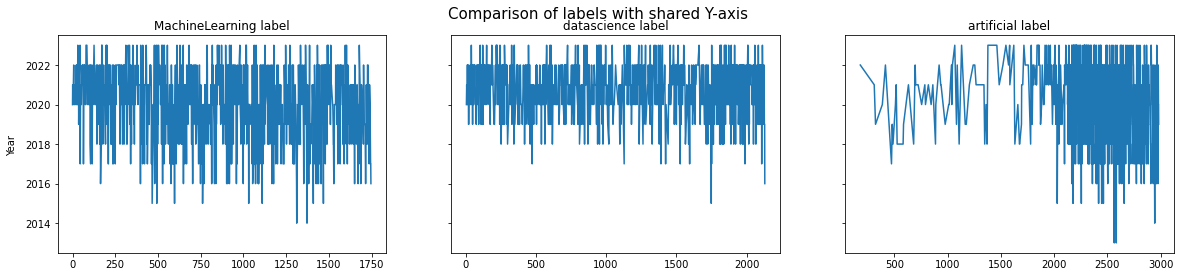

In [52]:
fig, axs = plt.subplots(1,3,sharey=True,figsize=(20,4))

## year
axs[0].plot(data[data.subreddit=='MachineLearning'].year)
axs[0].set_title('MachineLearning label')

axs[1].plot(data[data.subreddit=='datascience'].year)
axs[1].set_title('datascience label')

axs[2].plot(data[data.subreddit=='artificial'].year)
axs[2].set_title('artificial label')

fig.suptitle('Comparison of labels with shared Y-axis', fontsize=15)
fig.text(0.09, 0.5, 'Year', va='center', rotation='vertical')

plt.show()

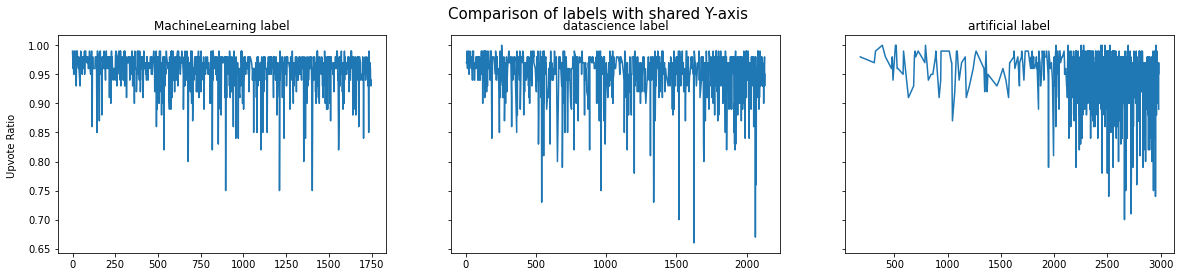

In [53]:
fig, axs = plt.subplots(1,3,sharey=True,figsize=(20,4))

## upvote_ratio
axs[0].plot(data[data.subreddit=='MachineLearning'].upvote_ratio)
axs[0].set_title('MachineLearning label')

axs[1].plot(data[data.subreddit=='datascience'].upvote_ratio)
axs[1].set_title('datascience label')

axs[2].plot(data[data.subreddit=='artificial'].upvote_ratio)
axs[2].set_title('artificial label')

fig.suptitle('Comparison of labels with shared Y-axis', fontsize=15)
fig.text(0.09, 0.5, 'Upvote Ratio', va='center', rotation='vertical')

plt.show()

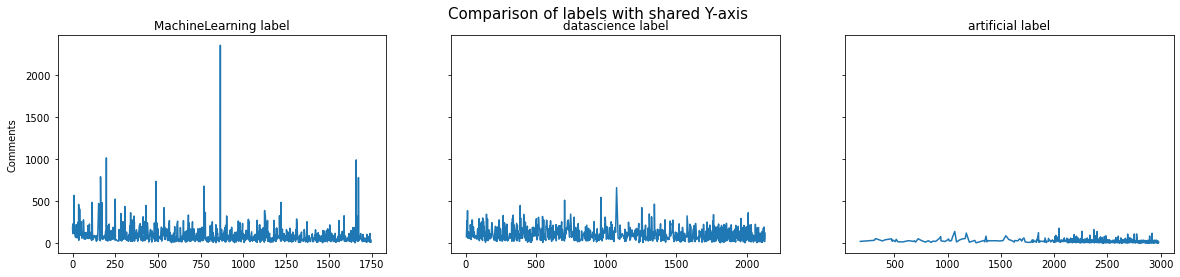

In [54]:
fig, axs = plt.subplots(1,3,sharey=True,figsize=(20,4))

## comments
axs[0].plot(data[data.subreddit=='MachineLearning'].comments)
axs[0].set_title('MachineLearning label')

axs[1].plot(data[data.subreddit=='datascience'].comments)
axs[1].set_title('datascience label')

axs[2].plot(data[data.subreddit=='artificial'].comments)
axs[2].set_title('artificial label')

fig.suptitle('Comparison of labels with shared Y-axis', fontsize=15)
fig.text(0.09, 0.5, 'Comments', va='center', rotation='vertical')

plt.show()

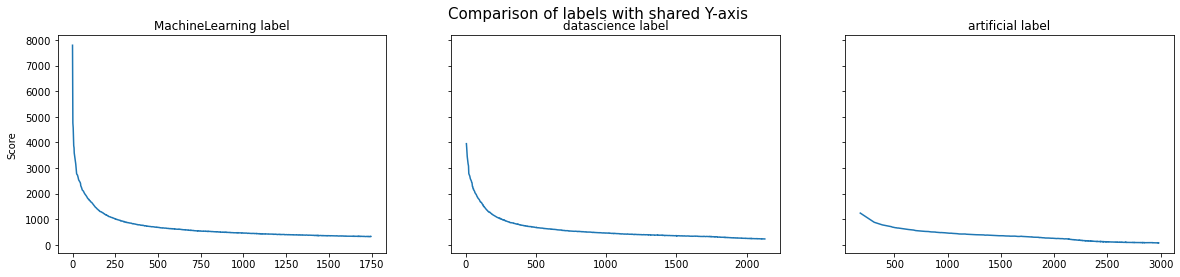

In [55]:
fig, axs = plt.subplots(1,3,sharey=True,figsize=(20,4))

## score
axs[0].plot(data[data.subreddit=='MachineLearning'].score)
axs[0].set_title('MachineLearning label')

axs[1].plot(data[data.subreddit=='datascience'].score)
axs[1].set_title('datascience label')

axs[2].plot(data[data.subreddit=='artificial'].score)
axs[2].set_title('artificial label')

fig.suptitle('Comparison of labels with shared Y-axis', fontsize=15)
fig.text(0.09, 0.5, 'Score', va='center', rotation='vertical')

plt.show()

### Observations -------------------------------
Looking at the graphs, it seems like -
- in case of comments feature, artificial is easily seperable by the other two classes
- in case of upvote_ratio feature, it does not seem to separate data as clearly
- in case of score feature, the artificial label is generally lower, hence relatively easier to seperate

Let's verify these hypothesis as we tune the random forest model

In [56]:
## prepare datasets
X = data[~data.flair_text.isna()]
X['flair_text'] = data.flair_text.dropna().astype(str).apply(preprocess)
y, y_org = data[~data.flair_text.isna()].subreddit.factorize()

## split the dataset into train-test-valid stratified split; to keep the ratio of classes same
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.15, 
                                                    random_state=42, 
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.10, 
                                                  random_state=42, 
                                                  stratify=y_train)
X_train.shape, y_train.shape

/var/folders/5h/15ddnjt54d3d9ss7ldf55hgc0000gn/T/ipykernel_87833/2461649720.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['flair_text'] = data.flair_text.dropna().astype(str).apply(preprocess)


((1863, 8), (1863,))

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Define the preprocessor
## Use One-hot-encoding to process the categorical (textual) variables
## Use scaling to normalize numeric features
preprocessor = ColumnTransformer([('cat', OneHotEncoder(), ['flair_text']), 
                                  ('num', StandardScaler(), ['score', 
                                                             'comments', 
                                                             'upvote_ratio', 
                                                             'year'])])

# Define the pipeline
clf = Pipeline([('preprocessor', preprocessor), ('clf', RandomForestClassifier(n_estimators=100, 
                                                                               random_state=42))])

In [58]:
## fit the pipeline
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['flair_text']),
                                                 ('num', StandardScaler(),
                                                  ['score', 'comments',
                                                   'upvote_ratio', 'year'])])),
                ('clf', RandomForestClassifier(random_state=42))])

In [59]:
## model performance
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

X_val, y_val = X_val[~X_val.flair_text.isin(['opinion'])], y_val[~X_val.flair_text.isin(['opinion'])]
y_pred_val = clf.predict(X_val)

print(f'Train Accuracy - {round(100*accuracy_score(y_train, y_pred_train),2)}%')
print(f'Test Accuracy - {round(100*accuracy_score(y_test, y_pred_test),2)}%')
print(f'Validation Accuracy - {round(100*accuracy_score(y_val, y_pred_val),2)}%\n')

print(f'Classification Report - \n{classification_report(y_test, y_pred_test)}')

Train Accuracy - 100.0%
Test Accuracy - 91.26%
Validation Accuracy - 85.92%

Classification Report - 
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       138
           1       0.91      0.89      0.90       130
           2       0.99      0.89      0.94        98

    accuracy                           0.91       366
   macro avg       0.92      0.91      0.91       366
weighted avg       0.92      0.91      0.91       366



In [60]:
perf_comp['title'].append('RF Cat + Num features')
perf_comp['train_acc'].append(round(100*accuracy_score(y_train, y_pred_train),2))
perf_comp['test_acc'].append(round(100*accuracy_score(y_test, y_pred_test),2))
perf_comp['valid_acc'].append(round(100*accuracy_score(y_val, y_pred_val),2))
perf_comp['clf'].append(clf)

### Observations --------------------------------------------
- The overall model performance is good, above 90%
- However there is some overfitting
- Model is still useful as it is ~90% accurate for testing and validation datasets

We can look at the feature importances provided by the random forest classifier to get an idea about the details of the model and understand the decision tree. 

In [61]:
# Get the feature importances
importances = clf.named_steps['clf'].feature_importances_

# Create a dataframe with feature names and importances
feature_importances = pd.DataFrame({'Feature': ['flair_text_'+str(i) for i in range(24)] + ['score', 'comments', 'upvote_ratio', 'year'], 
                                    'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importances)


          Feature  Importance
24          score    0.380288
25       comments    0.200198
27           year    0.068081
26   upvote_ratio    0.055558
18  flair_text_18    0.048130
0    flair_text_0    0.047541
2    flair_text_2    0.041683
14  flair_text_14    0.037163
15  flair_text_15    0.033372
5    flair_text_5    0.020604
3    flair_text_3    0.020573
9    flair_text_9    0.015279
22  flair_text_22    0.007973
11  flair_text_11    0.005218
16  flair_text_16    0.004599
20  flair_text_20    0.004339
1    flair_text_1    0.001462
21  flair_text_21    0.001351
4    flair_text_4    0.001214
6    flair_text_6    0.001080
13  flair_text_13    0.000952
7    flair_text_7    0.000768
10  flair_text_10    0.000544
12  flair_text_12    0.000502
19  flair_text_19    0.000467
8    flair_text_8    0.000461
23  flair_text_23    0.000422
17  flair_text_17    0.000176


### Experiment 2. D ------------------------------------
Let's try without the categorical features, as feature importance for those is not really great.

Tuning the hyper-parameters as well.

In [62]:
# Define the preprocessor
preprocessor = ColumnTransformer([('num', StandardScaler(), ['score', 
                                                             'comments', 
                                                             'upvote_ratio', 
                                                             'year'])])

# Define the pipeline
clf = Pipeline([('preprocessor', preprocessor), ('clf', RandomForestClassifier(n_estimators=50, 
                                                                               random_state=42,
                                                                                  criterion='gini',
                                                                                  max_depth=10,
                                                                                  min_samples_leaf=5))])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['score', 'comments',
                                                   'upvote_ratio', 'year'])])),
                ('clf',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=5,
                                        n_estimators=50, random_state=42))])

In [63]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

X_val, y_val = X_val[~X_val.flair_text.isin(['opinion'])], y_val[~X_val.flair_text.isin(['opinion'])]
y_pred_val = clf.predict(X_val)

print(f'Train Accuracy - {round(100*accuracy_score(y_train, y_pred_train),2)}%')
print(f'Test Accuracy - {round(100*accuracy_score(y_test, y_pred_test),2)}%')
print(f'Validation Accuracy - {round(100*accuracy_score(y_val, y_pred_val),2)}%\n')

print(f'Classification Report - \n{classification_report(y_test, y_pred_test)}')

Train Accuracy - 85.24%
Test Accuracy - 76.78%
Validation Accuracy - 73.79%

Classification Report - 
              precision    recall  f1-score   support

           0       0.70      0.84      0.76       138
           1       0.73      0.62      0.67       130
           2       0.94      0.86      0.90        98

    accuracy                           0.77       366
   macro avg       0.79      0.77      0.78       366
weighted avg       0.78      0.77      0.77       366



In [64]:
perf_comp['title'].append('RF Only Num features')
perf_comp['train_acc'].append(round(100*accuracy_score(y_train, y_pred_train),2))
perf_comp['test_acc'].append(round(100*accuracy_score(y_test, y_pred_test),2))
perf_comp['valid_acc'].append(round(100*accuracy_score(y_val, y_pred_val),2))
perf_comp['clf'].append(clf)

### ----------------------------------- Observations -----------------------------------

- Even without any textual data, the model is able to capture some trends and be significantly accurate.
- ~75% accuracy for multiclass problem is decent.
- The model seems to be less overfitting as well and pretty consistent in case of testing and validation dataset


- As discussed earlier, the most important feature turned out to be score and number of comments. Year turned out to be less important for the random forest classifier with this configuration.

## --------------------------- Support Vector Machine --------------------------
Support Vector Machine (SVM) is a powerful and widely used machine learning algorithm for classification, regression, and outlier detection. It works by finding the hyperplane that separates the data points in a high-dimensional feature space with maximum margin, where the margin is defined as the distance between the hyperplane and the closest data points. SVM can handle both linear and non-linear datasets using different kernel functions that map the data into a higher-dimensional space. SVM is known for its ability to generalize well and perform well on high-dimensional datasets.

For this specific dataset, SVM can be a good choice because it is a relatively small dataset with a moderate number of features. SVM can handle both categorical and numerical features, which are present in this dataset, and can be used for multi-class classification, which is the task for this dataset. However, SVM's performance may be affected by the imbalance in the target variable classes, as we saw in the Random Forest Classifier example.

### Experiment 3. A ------------------------------------
SVM on flair_text and Non-Textual features

In [65]:
# Define the preprocessor
preprocessor = ColumnTransformer([('cat', OneHotEncoder(), ['flair_text']), ('num', StandardScaler(), ['score', 'comments', 'upvote_ratio', 'year'])])

# Define the pipeline
clf = Pipeline([('preprocessor', preprocessor), ('clf', SVC(kernel='linear', C=1))])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['flair_text']),
                                                 ('num', StandardScaler(),
                                                  ['score', 'comments',
                                                   'upvote_ratio', 'year'])])),
                ('clf', SVC(C=1, kernel='linear'))])

In [66]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# X_val, y_val = X_val[~X_val.flair_text.isin(['opinion'])], y_val[~X_val.flair_text.isin(['opinion'])]
y_pred_val = clf.predict(X_val)

print(f'Train Accuracy - {round(100*accuracy_score(y_train, y_pred_train),2)}%')
print(f'Test Accuracy - {round(100*accuracy_score(y_test, y_pred_test),2)}%')
print(f'Validation Accuracy - {round(100*accuracy_score(y_val, y_pred_val),2)}%\n')

print(f'Classification Report - \n{classification_report(y_test, y_pred_test)}')

Train Accuracy - 87.49%
Test Accuracy - 87.7%
Validation Accuracy - 84.47%

Classification Report - 
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       138
           1       0.84      0.86      0.85       130
           2       0.98      0.88      0.92        98

    accuracy                           0.88       366
   macro avg       0.89      0.88      0.88       366
weighted avg       0.88      0.88      0.88       366



In [67]:
perf_comp['title'].append('SVM Cat + Num features')
perf_comp['train_acc'].append(round(100*accuracy_score(y_train, y_pred_train),2))
perf_comp['test_acc'].append(round(100*accuracy_score(y_test, y_pred_test),2))
perf_comp['valid_acc'].append(round(100*accuracy_score(y_val, y_pred_val),2))
perf_comp['clf'].append(clf)

### Observations ----------------------------

- The SVM algorithm also performs really well on this dataset.
- The model performance is highly balanced and is in a great ballpark as well.
- Both the precision and recall are high, which is a good sign for a balanced model.

In [68]:
# Define the preprocessor
preprocessor = ColumnTransformer([('cat', OneHotEncoder(), ['flair_text']), 
                                  ('num', StandardScaler(), ['score', 'comments', 'upvote_ratio', 'year'])])

# Define the pipeline
clf = Pipeline([('preprocessor', preprocessor), ('clf', SVC(kernel='rbf', C=3))])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['flair_text']),
                                                 ('num', StandardScaler(),
                                                  ['score', 'comments',
                                                   'upvote_ratio', 'year'])])),
                ('clf', SVC(C=3))])

In [69]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# X_val, y_val = X_val[~X_val.flair_text.isin(['opinion'])], y_val[~X_val.flair_text.isin(['opinion'])]
y_pred_val = clf.predict(X_val)

print(f'Train Accuracy - {round(100*accuracy_score(y_train, y_pred_train),2)}%')
print(f'Test Accuracy - {round(100*accuracy_score(y_test, y_pred_test),2)}%')
print(f'Validation Accuracy - {round(100*accuracy_score(y_val, y_pred_val),2)}%\n')

print(f'Classification Report - \n{classification_report(y_test, y_pred_test)}')

Train Accuracy - 90.23%
Test Accuracy - 88.25%
Validation Accuracy - 85.44%

Classification Report - 
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       138
           1       0.88      0.88      0.88       130
           2       0.93      0.88      0.91        98

    accuracy                           0.88       366
   macro avg       0.89      0.88      0.88       366
weighted avg       0.88      0.88      0.88       366



In [70]:
perf_comp['title'].append('SVM Cat + Num features (Tuned)')
perf_comp['train_acc'].append(round(100*accuracy_score(y_train, y_pred_train),2))
perf_comp['test_acc'].append(round(100*accuracy_score(y_test, y_pred_test),2))
perf_comp['valid_acc'].append(round(100*accuracy_score(y_val, y_pred_val),2))
perf_comp['clf'].append(clf)

### Observations ---------------------------
- After hyper-parameter tuning, the accuracy increases slightly
- The best hyperparameters are - Kernal : 'rbf', C : 3
- Just like before, the model's performance is highly balanced
- The model is >85% accurate for all testing and validation datasets
- The model does not show overfitting as well, can be seen by comparing train, test and validation accuracies

## ---------------------------------- Performance Comparison ----------------------------------



In [97]:
perf_comp

{'title': ['TF-IDF NB - Comment',
  'TF-IDF NB - Flair Text',
  'TF-IDF RF - Comment',
  'TF-IDF RF (Tuned) - Comment',
  'TF-IDF RF - Flair Text',
  'RF Cat + Num features',
  'RF Only Num features',
  'SVM Cat + Num features',
  'SVM Cat + Num features (Tuned)'],
 'train_acc': [66.96, 58.56, 100.0, 81.89, 64.68, 100.0, 85.24, 87.49, 90.23],
 'test_acc': [60.8, 63.11, 81.03, 78.12, 67.49, 91.26, 76.78, 87.7, 88.25],
 'valid_acc': [64.02, 61.84, 81.1, 77.56, 66.67, 85.92, 73.79, 84.47, 85.44],
 'clf': [Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]),
  Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]),
  Pipeline(steps=[('tfidf', TfidfVectorizer()),
                  ('clf', RandomForestClassifier(random_state=42))]),
  Pipeline(steps=[('tfidf', TfidfVectorizer()),
                  ('clf',
                   RandomForestClassifier(max_depth=10, min_samples_leaf=10,
                                          min_samples_split=50,
         

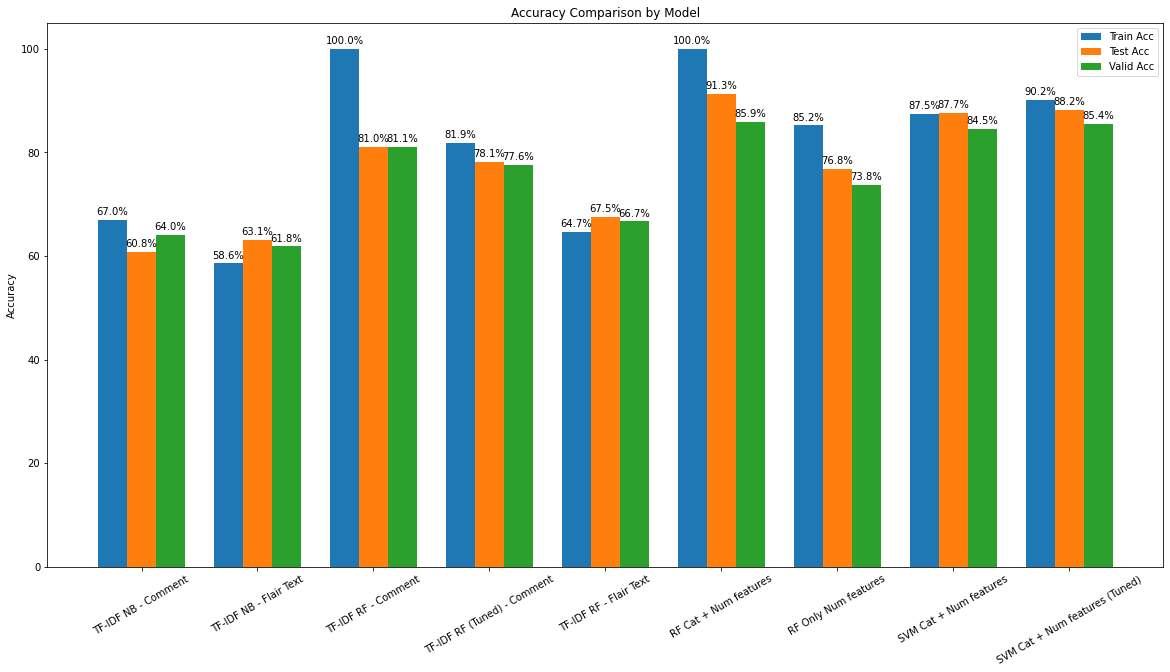

In [103]:
# set the x-axis labels
labels = perf_comp['title']

# set the y-axis data
train_data = perf_comp['train_acc']
test_data = perf_comp['test_acc']
valid_data = perf_comp['valid_acc']

# create the bar chart
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(20,10))
train_bars = ax.bar(x - width, train_data, width, label='Train Acc')
test_bars = ax.bar(x, test_data, width, label='Test Acc')
valid_bars = ax.bar(x + width, valid_data, width, label='Valid Acc')

# add labels, title, and legend
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)
ax.legend()

# add values above each bar
def label_plot(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', )

label_plot(train_bars)
label_plot(test_bars)
label_plot(valid_bars)

plt.show()

# ------------------------- Contribution ------------------------

The goal was to build a classifier algorithm to predict the categorical label - subreddit. The output has to be one of the classes - MachineLearning, datascience, or artificial. I have tried to compare multiple models and their hyper-parameters tuned versions to compare the model performances. This will tell us that which model is the best for this particular problem and its best configuration as well.

- I have worked with 4 different kinds of models : TF-IDF Naive Bayes, TF-IDF Random Forest Classifier, Random Forest Classifier, Support Vector Machine.
- In total, we have 9 model configurations to compare.
- I have tuned hyper-parameters wherever needed and see the output.
- I have stored every model configuration and output into a dictionary to compare all the models at the end of this exercise.
- In the plot above, we can observe the best model and its configuration is saved as an instance in the perf_comp dictionary as well.
- In the total 9 experiments, I have worked with both categorical and numerical features either together or alternatively to find out which features provides best prediction of target label.
- The best model comes out to be SVM with both categorical and numerical features. We can see that the model accuracy is the best among others without overfitting issue. The accuracy of 85% in validation dataset and 88% in testing dataset is a great indicator for a multiclass model.
- In the classification reports mentioned with each experiment, we can analyse that sometimes even if the accuracy is substantial, the model is not good for real world use because of worst performance in one of the classes. This was the case with experiment 1A, where we are building a Multinomail Naive Bayes classifier using TF-IDF vectorization.
- On the other end, the SVM model has the most balanced classification report.
- Hyper-Parameters are tuned for all the overfitting cases, where the testing and validation accuracy is substantial to analyse the real world performance of the respective model.

# ------------------------- References ------------------------

I have referred to some articles and documentation to understand the concepts used in this Project. Links are mentioned below -
- https://nlp.stanford.edu/IR-book/html/htmledition/support-vector-machines-and-machine-learning-on-documents-1.html#:~:text=An%20SVM%20is%20a%20kind,points%20as%20outliers%20or%20noise).
- https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e
- https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
- https://medium.com/@tenzin_ngodup/simple-text-classification-using-random-forest-fe230be1e857